# 1. Business Understanding

*   Problem Statement

    Home Credit ingin memprediksi probabilitas customer gagal bayar


*   Objective

    Mengidentifikasi high-risk applicant tanpa menolak good borrower.

*   Metric

    ROC-AUC
    
    Feature Importance

    Business interpretation

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Load Data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

train = pd.read_csv("/content/drive/MyDrive/Home Credit/application_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Home Credit/application_test.csv")
bureau = pd.read_csv("/content/drive/MyDrive/Home Credit/bureau.csv")
previous = pd.read_csv("/content/drive/MyDrive/Home Credit/previous_application.csv")
installments = pd.read_csv("/content/drive/MyDrive/Home Credit/installments_payments.csv")

print(train.shape)

(307511, 122)


# 3. EDA

### 3.1 Distribusi Target

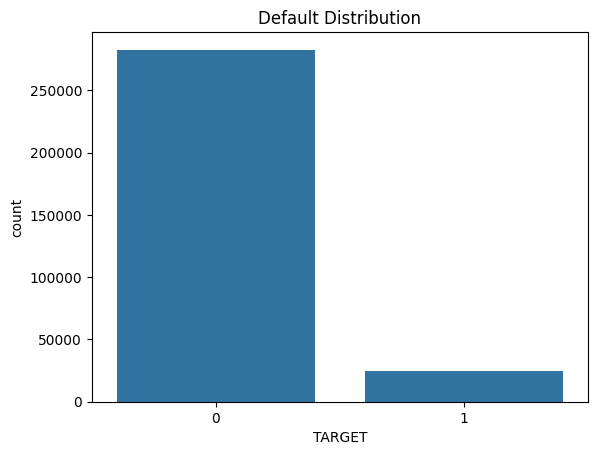

In [5]:
sns.countplot(x='TARGET', data=train)
plt.title("Default Distribution")
plt.show()

### 3.2 Distribusi Usia





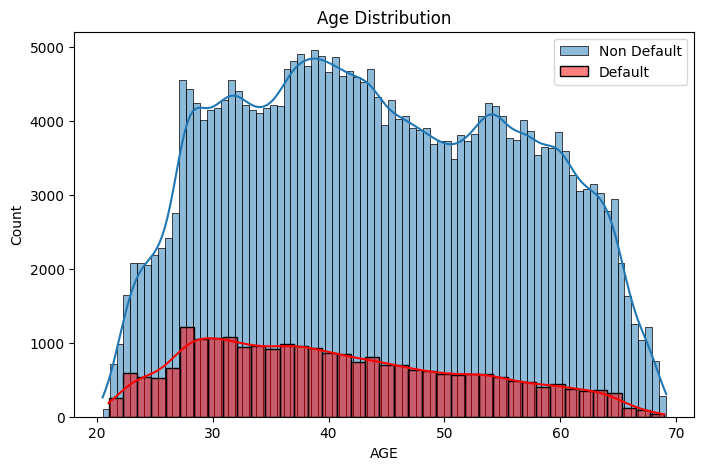

In [6]:
train['AGE'] = train['DAYS_BIRTH'] / -365

plt.figure(figsize=(8,5))
sns.histplot(train[train['TARGET']==0]['AGE'], label="Non Default", kde=True)
sns.histplot(train[train['TARGET']==1]['AGE'], label="Default", kde=True, color='red')
plt.legend()
plt.title("Age Distribution")
plt.show()

### 3.3 Distribusi Income Berdasarkan Status Pembayaran

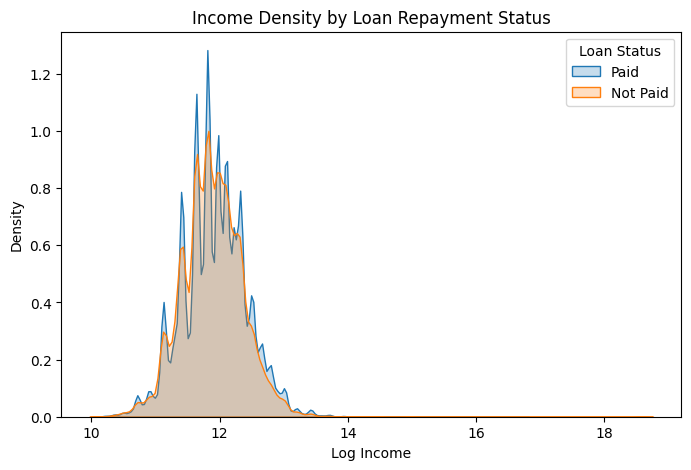

In [9]:
train['LOG_INCOME'] = np.log1p(train['AMT_INCOME_TOTAL'])

plt.figure(figsize=(8,5))

sns.kdeplot(
    train[train['TARGET']==0]['LOG_INCOME'],
    fill=True,
    label='Paid'
)

sns.kdeplot(
    train[train['TARGET']==1]['LOG_INCOME'],
    fill=True,
    label='Not Paid'
)

plt.legend(title="Loan Status")
plt.title("Income Density by Loan Repayment Status")
plt.xlabel("Log Income")
plt.ylabel("Density")
plt.show()

# 4. DATA CLEANING & PROCESSING

In [10]:
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

train['CREDIT_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
test['CREDIT_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']

train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

train, test = train.align(test, join='left', axis=1, fill_value=0)

print("Cleaned Shape:", train.shape)

/tmp/ipython-input-3778710082.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/tmp/ipython-input-3778710082.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Cleaned Shape: (307511, 233)


In [11]:
train.isnull().sum().sort_values(ascending=False).head(10)


,0
SK_ID_CURR,0
TARGET,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,0
AMT_GOODS_PRICE,0
REGION_POPULATION_RELATIVE,0
DAYS_BIRTH,0
DAYS_EMPLOYED,0


# 5. Baseline Model

In [12]:
X_base = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(
    X_base, y, test_size=0.2, random_state=42
)

log_base = LogisticRegression(max_iter=1000)
log_base.fit(X_train, y_train)

pred_log_base = log_base.predict_proba(X_val)[:,1]
auc_log_base = roc_auc_score(y_val, pred_log_base)

xgb_base = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb_base.fit(X_train, y_train)

pred_xgb_base = xgb_base.predict_proba(X_val)[:,1]
auc_xgb_base = roc_auc_score(y_val, pred_xgb_base)

print("Logistic Base AUC:", auc_log_base)
print("XGB Base AUC:", auc_xgb_base)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Base AUC: 0.6366479377624326
XGB Base AUC: 0.7592363099477026


# 6.MERGE EXTERNAL TABLES

In [13]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM':'sum',
    'AMT_CREDIT_SUM_DEBT':'sum',
    'DAYS_CREDIT':'mean'
}).reset_index()

prev_agg = previous.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION':'mean',
    'AMT_CREDIT':'mean'
}).reset_index()

installments['PAY_DIFF'] = (
    installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']
)

inst_agg = installments.groupby('SK_ID_CURR').agg({
    'PAY_DIFF':'mean'
}).reset_index()

In [14]:
train_ext = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train_ext = train_ext.merge(prev_agg, on='SK_ID_CURR', how='left')
train_ext = train_ext.merge(inst_agg, on='SK_ID_CURR', how='left')

test_ext = test.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_ext = test_ext.merge(prev_agg, on='SK_ID_CURR', how='left')
test_ext = test_ext.merge(inst_agg, on='SK_ID_CURR', how='left')

train_ext.fillna(0, inplace=True)
test_ext.fillna(0, inplace=True)

# 7. Model Dengan Merge

In [15]:
X_ext = train_ext.drop(['TARGET','SK_ID_CURR'], axis=1)
y_ext = train_ext['TARGET']

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_ext, y_ext, test_size=0.2, random_state=42
)

log_ext = LogisticRegression(max_iter=1000)
log_ext.fit(X_train2, y_train2)

pred_log_ext = log_ext.predict_proba(X_val2)[:,1]
auc_log_ext = roc_auc_score(y_val2, pred_log_ext)

xgb_ext = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=7,
    random_state=42
)

xgb_ext.fit(X_train2, y_train2)

pred_xgb_ext = xgb_ext.predict_proba(X_val2)[:,1]
auc_xgb_ext = roc_auc_score(y_val2, pred_xgb_ext)

print("Logistic Merge AUC:", auc_log_ext)
print("XGB Merge AUC:", auc_xgb_ext)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Merge AUC: 0.6500027693443166
XGB Merge AUC: 0.7673340160023727


# 8. ROC CURVE COMPARISON

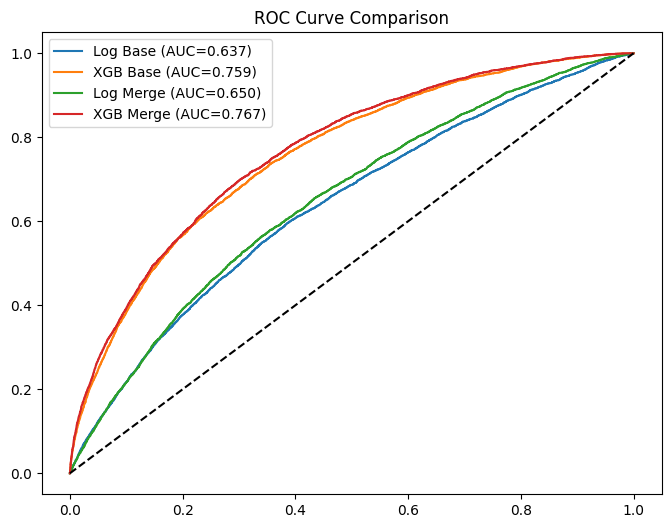

In [16]:
plt.figure(figsize=(8,6))

for y_true, pred, label in [
    (y_val, pred_log_base, f'Log Base (AUC={auc_log_base:.3f})'),
    (y_val, pred_xgb_base, f'XGB Base (AUC={auc_xgb_base:.3f})'),
    (y_val2, pred_log_ext, f'Log Merge (AUC={auc_log_ext:.3f})'),
    (y_val2, pred_xgb_ext, f'XGB Merge (AUC={auc_xgb_ext:.3f})')
]:
    fpr, tpr, _ = roc_curve(y_true, pred)
    plt.plot(fpr, tpr, label=label)

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()

# 9. Test

In [17]:
test_ids = test_ext['SK_ID_CURR']
test_features = test_ext.drop('SK_ID_CURR', axis=1)

test_features = test_features.reindex(columns=X_ext.columns, fill_value=0)

test_predictions = xgb_ext.predict_proba(test_features)[:,1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': test_predictions
})

submission.to_csv("submission.csv", index=False)

print(submission.head())

   SK_ID_CURR    TARGET
0      100001  0.026201
1      100005  0.175035
2      100013  0.032969
3      100028  0.026140
4      100038  0.114726
